Validation of noise models for single-cell transcriptomics

_Grün et al., Nature Methods, 2014_

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
from negbin_val_functions import *

read and prepare data

In [3]:
data = pd.read_csv("/home/npapado/Documents/data/GSE54695/GSE54695_data_transcript_counts.txt", sep = "\t")
print(data.shape)

spike_rows = [i for i, col in enumerate(data["GENENAME"]) if 'ERCC' in col]
data = data.drop(spike_rows, 0)
print(data.shape)

gene_names = data["GENENAME"].get_values()

data = data.drop("GENENAME", 1)
print(data.shape)

(12535, 321)
(12485, 321)
(12485, 320)


fit the different subsets separately

In [4]:
all2i = np.array([i for i, col in enumerate(data.columns) if '2i' in col])
allserum = np.array([i for i, col in enumerate(data.columns) if 'serum' in col])

cells = np.array([i for i, s in enumerate(data.columns) if "SC" in s])
controls = np.array([i for i, s in enumerate(data.columns) if "RNA" in s])

In [5]:
cells2i = np.intersect1d(cells, all2i)
cellsserum = np.intersect1d(cells, allserum)

In [6]:
# see Quantification of transcript abundance in Grün et al. for Pou5f control
X = np.array(data).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
pou5f = [i for i, col in enumerate(gene_names[relevant]) if 'Pou5f' in col][0]
X = X[keep][:, relevant]
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)

X = (X.transpose() / scalings).transpose()
not_differentiating = np.where(X[:, pou5f] > 10)
X = X[:, not_differentiating]

In [7]:
X = np.array(data.iloc[:,cells2i]).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
X = X[keep][:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("gse5/cells2i_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("gse5", "cells2i", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


In [8]:
X = np.array(data.iloc[: ,cellsserum]).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
X = X[keep][:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("gse5/serum_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("gse5", "serum", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.9999999999999998 0.5516772116132427


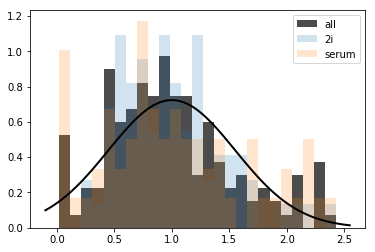

In [9]:
# scaling factors
fig, ax = plt.subplots()

data2i = np.array(data.iloc[: ,cells2i]).transpose()
keep2i = np.sum(data2i, axis=1) > 1000
dataserum = np.array(data.iloc[: ,cellsserum]).transpose()
keepserum = np.sum(dataserum, axis=1) > 1000

sum1 = np.sum(data2i[keep2i], axis=1)
sum2 = np.sum(dataserum[keepserum], axis=1)
sum_all = np.concatenate([sum1, sum2])

from scipy.stats import norm
scalings = sum_all / np.mean(sum_all)
mu, std = norm.fit(scalings)

all_n, all_bins, all_patches = ax.hist(scalings, bins=25, normed=True, alpha=0.7, color='black', label="all")

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
print(mu, std)

ax.hist(sum1/np.mean(sum1), bins=all_bins, normed=True, alpha=0.2, label="2i")
np.savetxt("gse5/cells2i_scalings.txt", sum1/np.mean(sum1))
ax.hist(sum2/np.mean(sum2), bins=all_bins, normed=True, alpha=0.2, label="serum")
np.savetxt("gse5/serum_scalings.txt", sum2/np.mean(sum2))
ax.legend()
plt.show()

In [10]:
data2i = np.array(data.iloc[: ,cells2i]).transpose()
keep2i = np.sum(data2i, axis=1) > 1000
dataserum = np.array(data.iloc[: ,cellsserum]).transpose()
keepserum = np.sum(dataserum, axis=1) > 1000

X = data2i[keep2i]
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("gse5/cells2i_genes.txt", gene_means)

X = dataserum[keepserum]
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("gse5/serum_genes.txt", gene_means)